Module und Funktionen laden:

In [42]:
#@author: maxim
"""

# -*- coding: utf-8 -*-

Created on Sat Nov 16 17:55:59 2024

@author: maxim
"""
"""Funktionen"""


import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from cycler import cycler
from scipy.signal import savgol_filter
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fmin, minimize
import glob
import matplotlib.gridspec as gridspec






"""Funktionen"""
def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    temp_df = np.array(pd.read_csv(initpath, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
    return temp_df
    

def filtplot(array,line1,line2,plot,col):
    temp=array[array[:,1]>=line1]
    temp=temp[temp[:,1]<=line2]
    if plot: plt.plot(temp[:,0]-temp[0,0],temp[:,col])
    
    return temp


def ocv(array,line):
    temp=[]
    for i in range(len(array)):
        if array[i-1,1]==line and (array[i,1]==line+1 or array[i,1]==line-1):
            temp.append(array[i-1,:])
            
    return np.array(temp)

def dva(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            UAh = dU/dAh
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataAh[i]])
    data=np.array(data)
    return data

def ica(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            UAh = dAh/dU
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataAh[i]])
    data=np.array(data)
    return data

def hppc(array,line):
    temp=array[array[:,1]==line]
    U1=temp[:,2]
    time=temp[:,0]
    # I=temp[:,3]
    
    return np.column_stack([time,U1])


def interp(ydata, xval):
    xq = np.arange(0,100,0.5)    

    x = np.array(xval, dtype=float)

    vq = interp1d(x, ydata)
    yint = vq(xq)
    return np.column_stack([xq,yint])


def consecutive(data, stepsize=3):
    return np.split(data, np.where(np.diff(data[:,0]) >= stepsize)[0]+1)

def consecutive_neu(data, stepsize=1.5):
    # Berechne Differenzen in der Zeitspalte (data[:, 0]) und in der Testspalte (data[:, 1])
    time_diff = np.diff(data[:, 0])
    test_diff = np.diff(data[:, 1])
    
    # Bedingung: Zeitdifferenz >= stepsize und Veränderung in der Testspalte
    split_indices = np.where((time_diff >= stepsize) & (test_diff != 0))[0] + 1
    
    # Array an den ermittelten Indizes aufteilen
    return np.split(data, split_indices)

def calcRi(data, datapoints):
    deltaU = data[datapoints-1,3] - data[datapoints,3]
    return abs(deltaU / data[datapoints-1,4])

def cost_func(initial_param,x,y,charge):
    J = sum(np.sqrt((y - model_func_par(x,charge,initial_param))**2))
    return J


    
def process_array(array):
    # Schritt 1: Umbruch zwischen Millisekunden- und Sekunden-Schritten finden
    diff = np.diff(array[:,0])
    break_point = np.where(diff > 0.1)[0][0] + 1  # +1, da diff eine Position weniger hat

    # Schritt 2: Werte vor dem Umbruch auf Sekundentakt zuschneiden
    pre_break_values = array[:break_point,:]
    pre_break_values = pre_break_values[::100]  # Nur jeden 100. Wert beibehalten, da 10ms -> 0.1s

    # Schritt 3: Werte nach dem Umbruch beibehalten
    post_break_values = array[break_point:,:]

    # Kombination der Arrays
    processed_array = np.concatenate((pre_break_values, post_break_values))

    return processed_array


def model_func_par(t, charge, param):
    U1, tau1, U2, tau2 = param
    if charge:
        return U1 * np.exp(-t/tau1) + U2 * np.exp(-t/tau2)
    else:
        return U1 * ( 1- np.exp(-t/tau1)) + U2 * (1 - np.exp(-t/tau2))
    
    
def hppc_fit(array,lines,strom):
    puls_temp=[]
    temp=filtplot(array,lines[1],lines[2],plot=0,col=2)
    U1_temp=temp[:,2]
    time_temp=temp[:,0]
    splitted_temp=np.column_stack([time_temp,U1_temp])
    splitted_temp=splitted_temp.astype(float)
    splitted=consecutive(splitted_temp)
    for i in range(len(splitted)):
        splitted[i]=process_array(splitted[i])
    
    strom_temp=filtplot(array,lines[0],lines[0],plot=0,col=3)
    strom_split=consecutive(strom_temp)
    strome=[]
    for i in range(len(strom_split)):
        if strom_split[i][-1,3]<0:
            laden=0
        else:
            laden=1
        strome.append(strom_split[i][-1,3]) 
        
    R0=[]
    fit_ges=np.array([])
    plot_ges=[]
    for i in range(len(splitted)):
        if i<len(strome):
            R0= abs((splitted[i][0,1]-strom_split[i][-1,2]) / strome[i])
        x=splitted[i][1:,0] - splitted[i][0,0] #delta Zeit als x-Werte
        x = x[:]
        
        if splitted[i][0,1] > splitted[i][-1,1]:
            y = splitted[i][1:,1] - splitted[i][-1,1] #delta U als y-Werte
        else:
            y = splitted[i][1:,1] - splitted[i][0,1]
        initial_param = np.array([0.1, 10, 0.2, 100])
       
        solution = fmin(cost_func,initial_param,args=(x,y,laden))  
        
        plotVal = model_func_par(x,laden, solution)
        plot_ges.append(plotVal)
        if i<len(strome):
            R1=solution[0]/abs(strome[i])
            C1=solution[1]/R1
            R2=solution[2]/abs(strome[i])
            C2=solution[3]/R2
            fit=np.array([R0,R1,C1,R2,C2])
    
            if i==0:
                fit_ges=fit
            else:
                fit_ges=np.column_stack([fit_ges,fit])
    return plot_ges,fit_ges

def model_func(t, U1, tau1, U2, tau2, charge):
    if charge:
        return U1 * np.exp(-t / tau1) + U2 * np.exp(-t / tau2)
    else:
        return U1 * (1 - np.exp(-t / tau1)) + U2 * (1 - np.exp(-t / tau2))

def fit_with_curve_fit(x, y, charge):
    # Initiale Parameterwerte
    # initial_param = [0.05, 300, 0.05, 300] # [U1, tau1, U2, tau2]
    initial_param = [0.1, 10, 0.1, 100] 

    
    # Grenzen für die Parameter
    bounds_lower = [0, 1, 0, 1]  # Untere Grenzen: U1, tau1, U2, tau2
    # bounds_upper = [0.1, 600, 0.1, 600]  # Obere Grenzen: U1, tau1, U2, tau2
    bounds_upper = [1, 50, 1, 400]  

    
    # Anonyme Funktion für die Richtung (Laden/Entladen)
    def model_to_fit(t, U1, tau1, U2, tau2):
        return model_func(t, U1, tau1, U2, tau2, charge)
    
    # Curve Fit anwenden
    popt, pcov = curve_fit(
        model_to_fit, x, y, p0=initial_param, bounds=(bounds_lower, bounds_upper)
    )
    return popt, pcov

def hppc_fit_grenzen(array, lines, strom):
    puls_temp = []
    temp = filtplot(array, lines[1], lines[2], plot=0, col=2)
    # U1_temp = temp[:, 2]
    # time_temp = temp[:, 0]
    # cap_temp = temp[:,4]
    # splitted_temp = np.column_stack([time_temp, U1_temp,cap_temp])
    splitted_temp = temp.astype(float)
    splitted = consecutive_neu(splitted_temp)
    for i in range(len(splitted)):
        splitted[i] = process_array(splitted[i])

    strom_temp = filtplot(array, lines[0], lines[0], plot=0, col=3)
    strom_split = consecutive(strom_temp)
    strome = []
    for i in range(len(strom_split)):
        if strom_split[i][-1, 3] < 0:
            laden = 0
        else:
            laden = 1
        strome.append(strom_split[i][-1, 3])

    R0 = []
    U0 = []
    IR=np.array([])
    fit_ges = np.array([])
    plot_ges = []
    for i in range(len(splitted)):
        if i < len(strome):
            R0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2]) / strome[i])
            U0 = abs((splitted[i][0, 2] - strom_split[i][-1, 2]))
            UOCV=splitted[i][-1,2]
        x = splitted[i][1:, 0] - splitted[i][0, 0]  # delta Zeit als x-Werte
        x = x[:]
        if splitted[i][0, 2] > splitted[i][-1,2]:
            y = splitted[i][1:, 2] - splitted[i][-1,2]  # delta U als y-Werte
        else:
            y = splitted[i][1:, 2] - splitted[i][0, 2]

        # Curve Fit anwenden
        try:
            solution, covariance = fit_with_curve_fit(x, y, laden)
            plotVal = model_func(x, solution[0], solution[1], solution[2], solution[3], laden)
            plot_ges.append(plotVal)

            if i < len(strome):
                cap=np.mean(splitted[i][:,4])
                R1 = solution[0] / abs(strome[i])
                Tau1 = solution[1] 
                R2 = solution[2] / abs(strome[i])
                Tau2 = solution[3] 
                fit = np.array([cap,R0, R1, Tau1, R2, Tau2])
                mod=np.array([cap,UOCV,U0])
                if i == 0:
                    fit_ges = fit
                    IR=mod
                else:
                    fit_ges = np.column_stack([fit_ges, fit])
                    IR = np.column_stack([IR, mod])

        except RuntimeError as e:
            print(f"Curve fitting failed for pulse {i}: {e}")
            
    if laden==1:
        IR[0,:]-=IR[0,0]
        fit_ges[0,:]-=fit_ges[0,0]
        # SOC=fit_ges[0,:]/fit_ges[0,-1]
    elif laden==0:
        IR[0,:]-=IR[0,-1]
        fit_ges[0,:]-=fit_ges[0,-1]
    else:
        print("Fehler bei Laderichtungsbestimmung")
    SOC_vol=np.array([fit_ges[0,:],IR[0,:]])
    
    
    return plot_ges, fit_ges,strom_split,IR


def cost_func2(initial_param,x,y):
    J = sum(np.sqrt((y - model2(x,y,initial_param))**2))
    return J

# def cost_func2(param, x, y):
#     residuals = y - model2(x, y, param)
#     penalty = 1000 * abs(model2(0, 0, param))  # Optional: erzwinge (0,0)
#     return np.sum(residuals**2) + penalty

def model2(U0,I, param):
    I0, alpha, R = param
    z = 1  # Anzahl der übertragenen Elektronen (z.B. für Li+)
    F = 96485.3329  # Faraday-Konstante (C/mol)
    R_const = 8.3145  # Universelle Gaskonstante (J/mol/K)
    T = 298.15  # Absolute Temperatur (in Kelvin)

    # Aktivierungsüberpotentialterm
    hct = U0 - I*R

    # Butler-Volmer-Gleichung
    return I0 * (
        np.exp((alpha * z * F / (R_const * T)) * hct) -
        np.exp(-(1 - alpha) * z * F / (R_const * T) * hct)
    )

def butler_volmer_fit(testdictV):

    butler_fit_t=np.array([])
    butler_plot_t={}
    for a in range(len(testdictV["C/2 ch"]["U"][0,:])):
        Udata=[0]
        Idata=[0]
        for i in testdictV.keys():
            if "5.1A" not in i and "1.5C" not in i:
                Udata.append(testdictV[i]["U"][1,a])
                Idata.append(testdictV[i]["I"])
                print(i)
        Udata=np.sort(np.array(Udata))
        Idata=np.sort(np.array(Idata))
        
        ###
        Udata = np.append(Udata, 0)
        Idata = np.append(Idata, 0)
        ###

        p0 = [1.5, 0.5, 0.01]  # Startwerte: I0, alpha, IR
        # bounds = (
        #     [0, 0.1, 0.01],  # Untergrenzen: I0, alpha, IR
        #     [1.0, 2, 10],     # Obergrenzen: I0, alpha, IR
        # )

        # popt, pcov = curve_fit(
        #     model2, I_data, U_data,
        #     p0=p0, bounds=bounds
        # )
        solution = fmin(cost_func2,p0,args=(Udata,Idata))  
        # Ausgabe der Fit-Ergebnisse
        I0_fit, alpha_fit, R_fit = solution
        print(f"Fit-Ergebnisse:\nI0: {I0_fit:.4e}\nalpha: {alpha_fit:.4f}\nR: {R_fit:.4f}")

        # Fit-Kurve berechnen
        Ufit = np.linspace(min(Udata), max(Udata), 100)
        Ifit=np.linspace(min(Idata),max(Idata),100)
        Ifitted = model2(Ufit,Ifit, solution)
        
        fit_t=np.array([testdictV["C/2 ch"]["U"][0,a],I0_fit, alpha_fit, R_fit])
        plot_t=np.array([Ufit,Ifitted]).T
        if a == 0:
            butler_fit_t = fit_t
        else:
            butler_fit_t = np.column_stack([butler_fit_t, fit_t])
        vol=testdictV["C/2 ch"]["U"][0,a]
        butler_plot_t[f"{vol:.4f}"]=plot_t 
        
        
    return butler_fit_t,butler_plot_t

from matplotlib import rcParams



Layout der Plots

In [19]:
from cycler import cycler
"""
Plot Farbeinstellungen
"""
plt.style.use('seaborn-v0_8')

default_cycler = (cycler(color=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']))
plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams["legend.fontsize"] = 18
fontsize = 20
labelsize=20

In [2]:
"""Daten laden"""
initpath=r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\OCV_daten"

# initpath=r"C:\Users\Dominik\tubCloud\Studis\Austausch_Max\Projekt_Entropie\OCV_daten"
datei="dS24NCA10_ButlerVolmerGITT.txt"
datei2="dS24NCA10_ButlerVolmerGITT_lowI.txt"
data_raw=load(initpath,datei,skip=0,separation=" ")
data_temp=np.delete(data_raw,[1,2,3,5,10,12,13],1)
data=data_temp
data_raw2=load(initpath,datei2,skip=0,separation=" ")
data_temp2=np.delete(data_raw2,[1,2,3,5,10,12,13],1)
data2=data_temp2

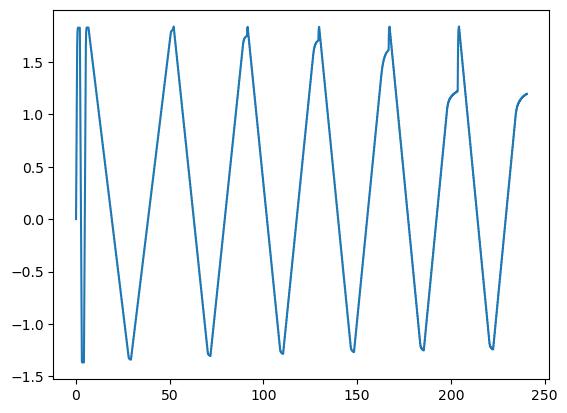

In [3]:
test=filtplot(data,0,109,plot=1,col=4)

OCV Arrays werden erstellt für die beiden Tests erstellt:

In [4]:
lines_iOCV_dis=[[19,20,21],[35,36,37],[51,52,53],[67,68,69],[83,84,85],[99,100,101]]
lines_iOCV_ch=[[27,28,29],[43,44,45],[59,60,61],[75,76,77],[91,92,93],[107,108,109]]
OCV={"ch":{},"dis":{}}
c_rate=["C/5","C/2","3C/4","1C","1.5C","5.1A"]
c_rate2=["C/20","C/10"]


l=0
   
for i in lines_iOCV_ch:
    tempch=filtplot(data,i[0],i[2],plot=0,col=2)

    OCV["ch"][c_rate[l]]=np.asarray(tempch,dtype=np.float64)

    l+=1
    
    
l=0
for i in lines_iOCV_ch[:2]:
    tempch=filtplot(data2,i[0],i[2],plot=0,col=2)

    OCV["ch"][c_rate2[l]]=np.asarray(tempch,dtype=np.float64)

    l+=1
    
l=0 
for i in lines_iOCV_dis:
    tempdis=filtplot(data,i[0],i[2],plot=0,col=2)

    OCV["dis"][c_rate[l]]=np.asarray(tempdis,dtype=np.float64)

    l+=1
    
l=0
for i in lines_iOCV_dis[:2]:
    tempdis=filtplot(data2,i[0],i[2],plot=0,col=2)

    OCV["dis"][c_rate2[l]]=np.asarray(tempdis,dtype=np.float64)

    l+=1

    


2RC Fit für die einzelnen C-Raten

In [5]:
fit_all={}
plot_all={}
hppc_data=[]
IR_all={}
l=0
for a in range(len(lines_iOCV_ch)):
    #Ladepulse(27,28)
    #Entladepulse(20,21)
    lines=[lines_iOCV_dis[a],lines_iOCV_ch[a]]
    data_t=data.copy()
    data_t[:,0]=data_t[:,0]*3600
    strome=[]
    for i in range(len(lines)):
        temp=filtplot(data_t,lines[i][1],lines[i][2],plot=0,col=3)
        temp=temp.astype(float)
        temp=consecutive_neu(temp) 
        # for i in range(len(temp)):
        #     temp[i]=process_array(temp[i])
        hppc_data.append(temp)
    plot_data,fit_data,IR_data=[],[],[]
    for i in range(len(lines)):
        plot_temp,fit_temp,strom,IR =hppc_fit_grenzen(data_t,lines[i],0)
        fit_temp=np.vstack([fit_temp])
        plot_data.append(plot_temp)
        fit_data.append(fit_temp)
        IR_data.append(IR)
    plot_all[c_rate[l]]=plot_data
    fit_all[c_rate[l]]=fit_data    
    IR_all[c_rate[l]]=IR_data
    l+=1
l=0    
for a in range(len(lines_iOCV_ch[:2])):
    #Ladepulse(27,28)
    #Entladepulse(20,21)
    lines=[lines_iOCV_dis[a],lines_iOCV_ch[a]]
    data_t=data2.copy()
    data_t[:,0]=data_t[:,0]*3600
    strome=[]
    for i in range(len(lines)):
        temp=filtplot(data_t,lines[i][1],lines[i][2],plot=0,col=3)
        temp=temp.astype(float)
        temp=consecutive_neu(temp) 
        # for i in range(len(temp)):
        #     temp[i]=process_array(temp[i])
        hppc_data.append(temp)
    plot_data,fit_data,IR_data=[],[],[]
    for i in range(len(lines)):
        plot_temp,fit_temp,strom,IR =hppc_fit_grenzen(data_t,lines[i],0)
        fit_temp=np.vstack([fit_temp])
        plot_data.append(plot_temp)
        fit_data.append(fit_temp)
        IR_data.append(IR)
    plot_all[c_rate2[l]]=plot_data
    fit_all[c_rate2[l]]=fit_data    
    IR_all[c_rate2[l]]=IR_data
    l+=1


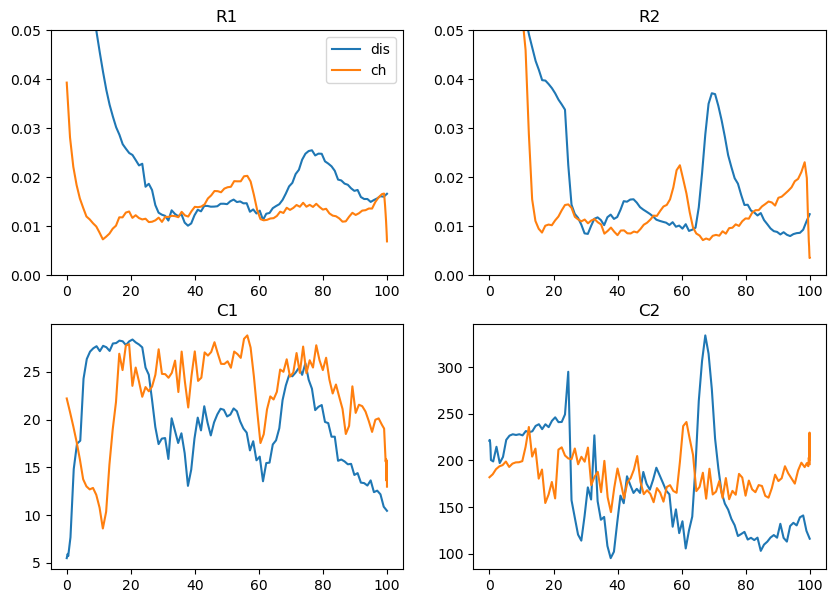

In [6]:
c="C/5"
fig,axes=plt.subplots(2,2,figsize=(10, 7))
axes[0,0].plot(fit_all[c][0][0,:]/fit_all[c][0][0,0]*100,fit_all[c][0][2,:],label="dis")
axes[1,0].plot(fit_all[c][0][0,:]/fit_all[c][0][0,0]*100,fit_all[c][0][3,:])
axes[0,1].plot(fit_all[c][0][0,:]/fit_all[c][0][0,0]*100,fit_all[c][0][4,:])
axes[1,1].plot(fit_all[c][0][0,:]/fit_all[c][0][0,0]*100,fit_all[c][0][5,:])
axes[0,0].plot(fit_all[c][1][0,:]/fit_all[c][1][0,-1]*100,fit_all[c][1][2,:],label="ch")
axes[1,0].plot(fit_all[c][1][0,:]/fit_all[c][1][0,-1]*100,fit_all[c][1][3,:])
axes[0,1].plot(fit_all[c][1][0,:]/fit_all[c][1][0,-1]*100,fit_all[c][1][4,:])
axes[1,1].plot(fit_all[c][1][0,:]/fit_all[c][1][0,-1]*100,fit_all[c][1][5,:])
axes[0, 0].set_ylim(0, 0.05) 
axes[0, 1].set_ylim(0, 0.05)
axes[0,0].set_title("R1")
axes[0,1].set_title("R2")
axes[1,0].set_title("C1")
axes[1,1].set_title("C2")
axes[0,0].legend()
plt.show()

Parameter der 2RC Fits für jede C-Rate:

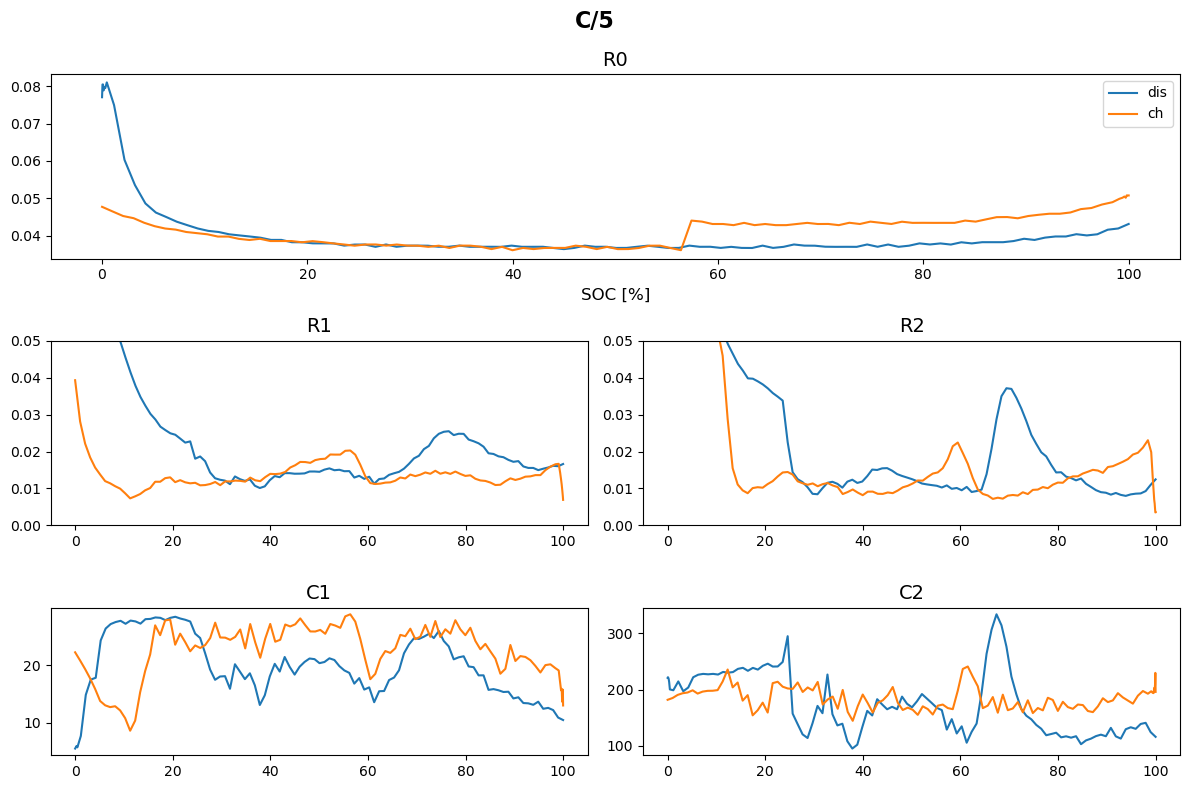

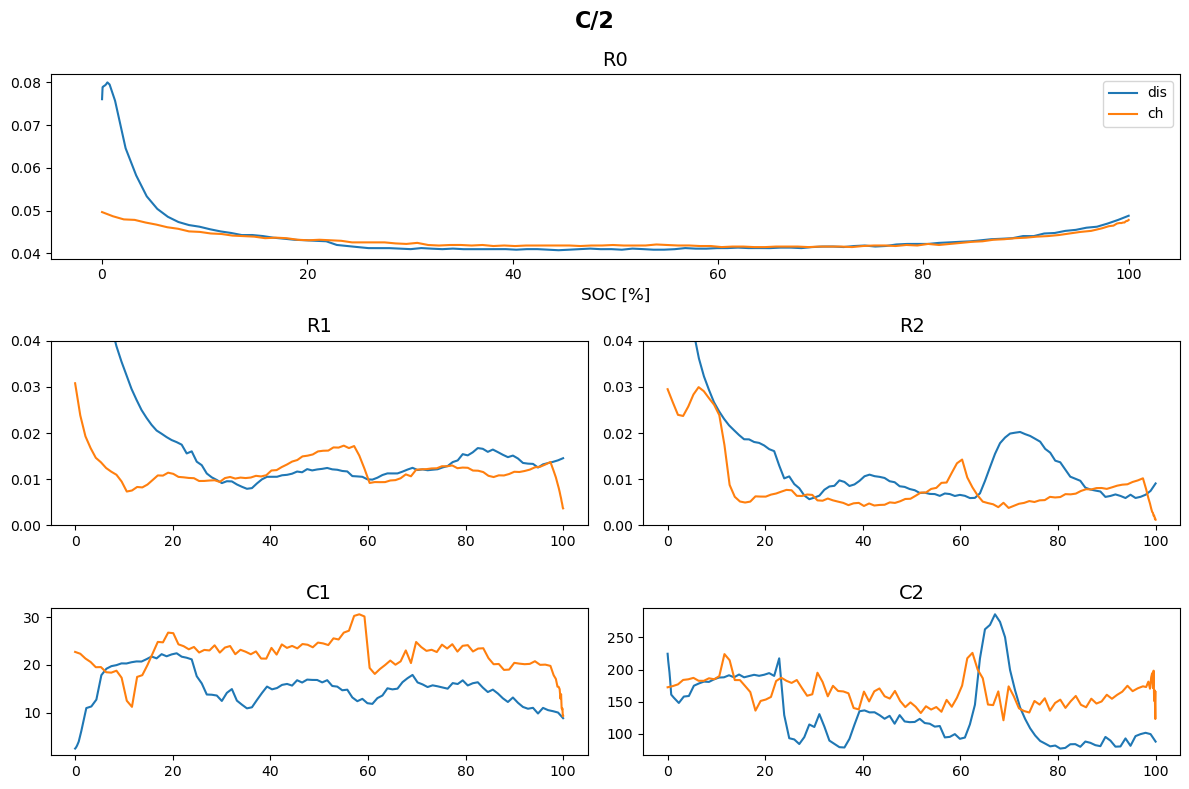

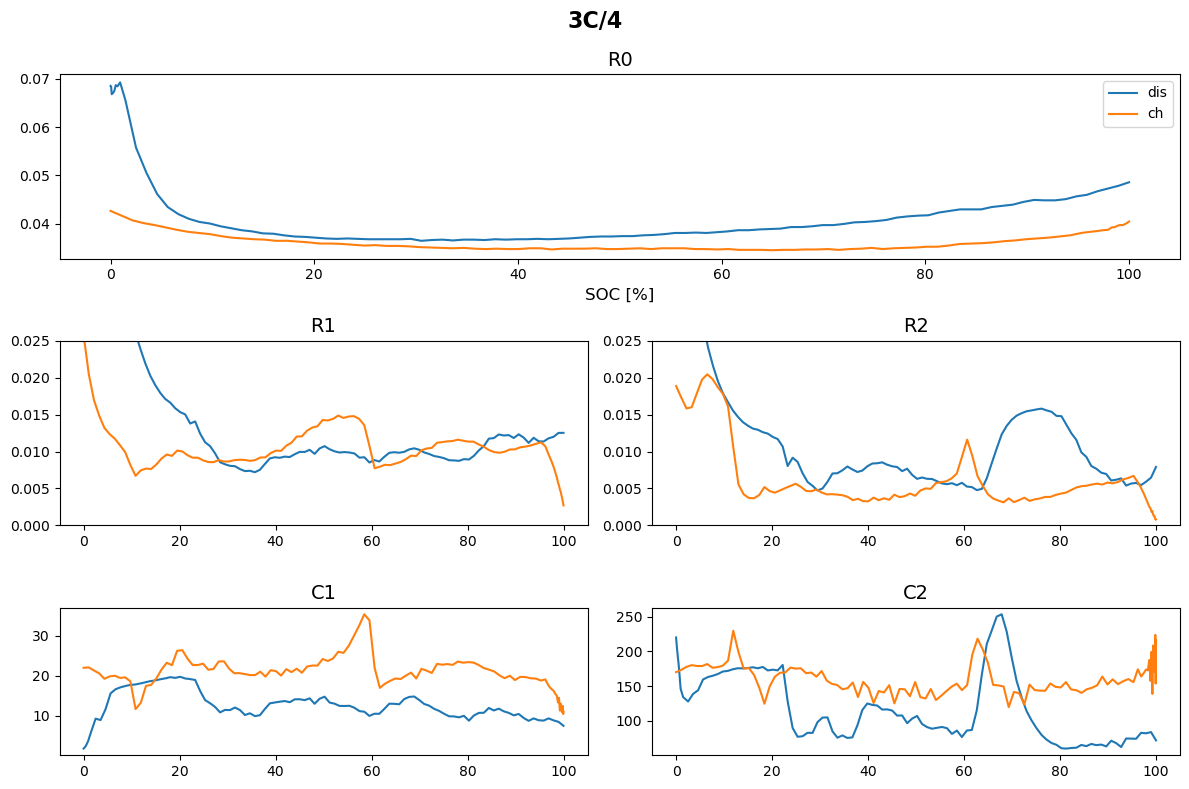

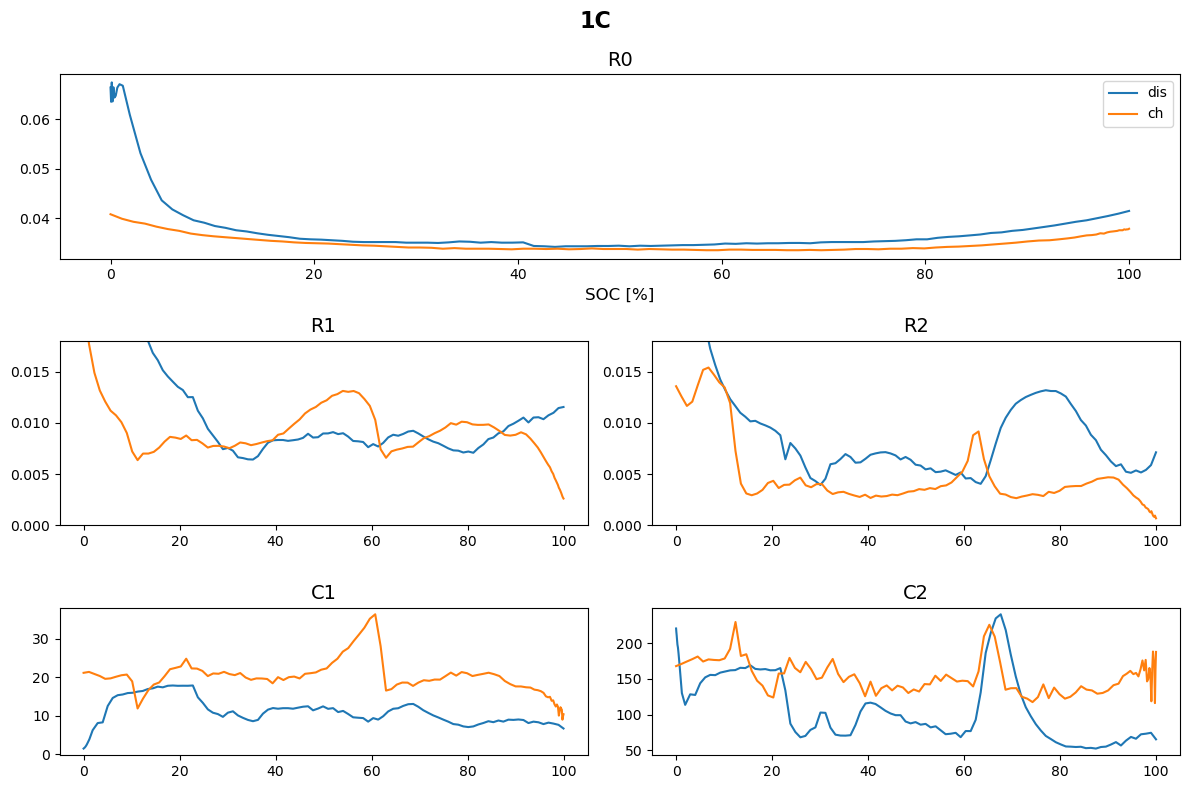

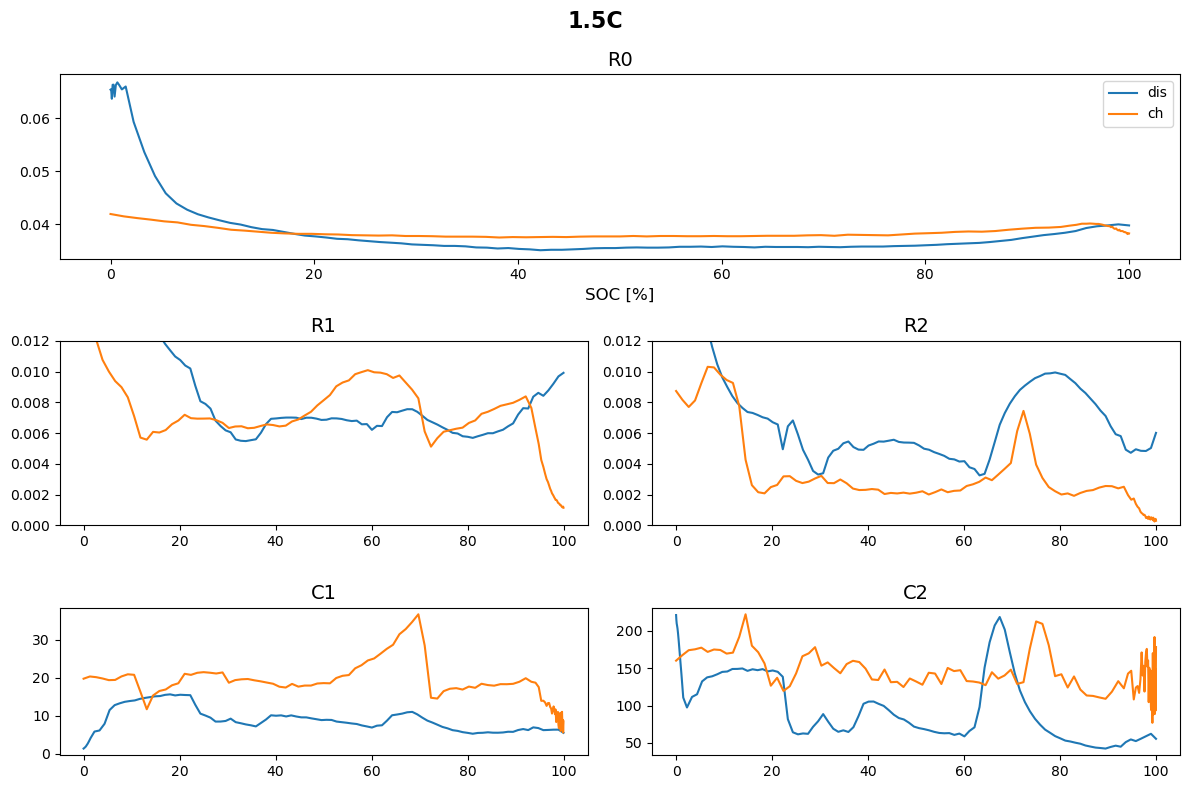

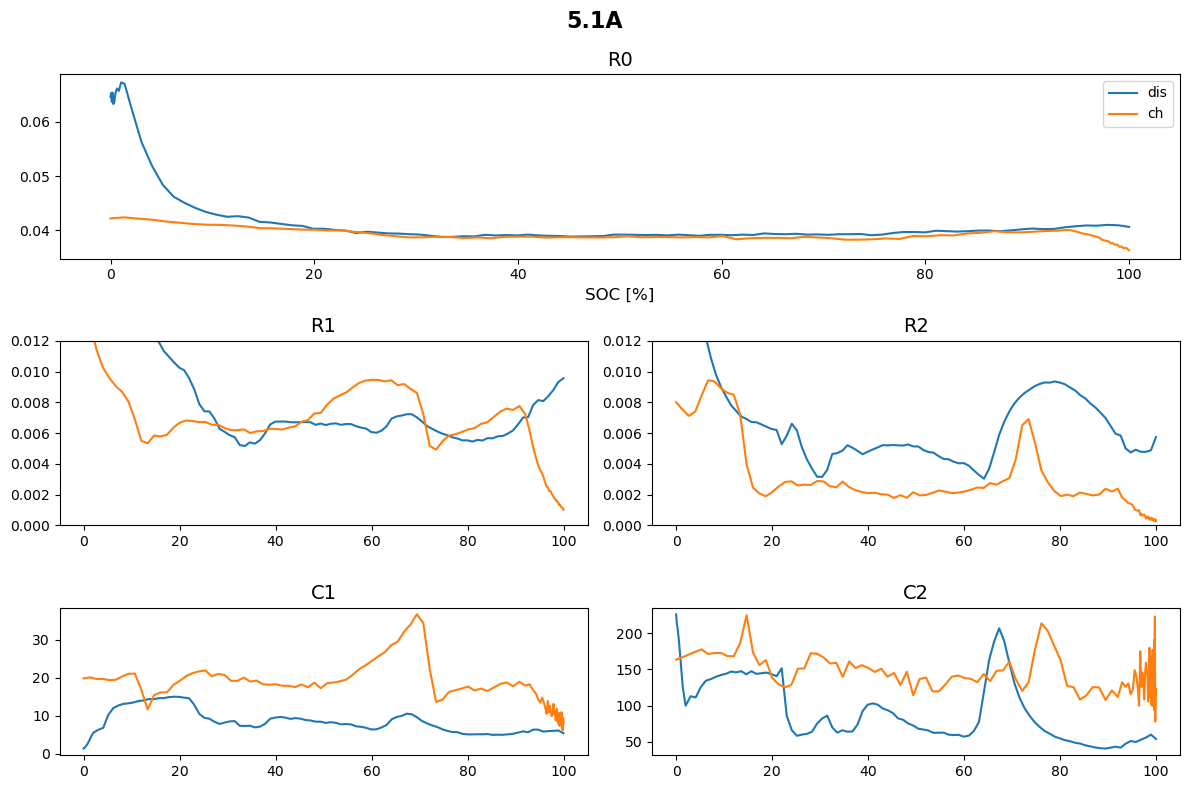

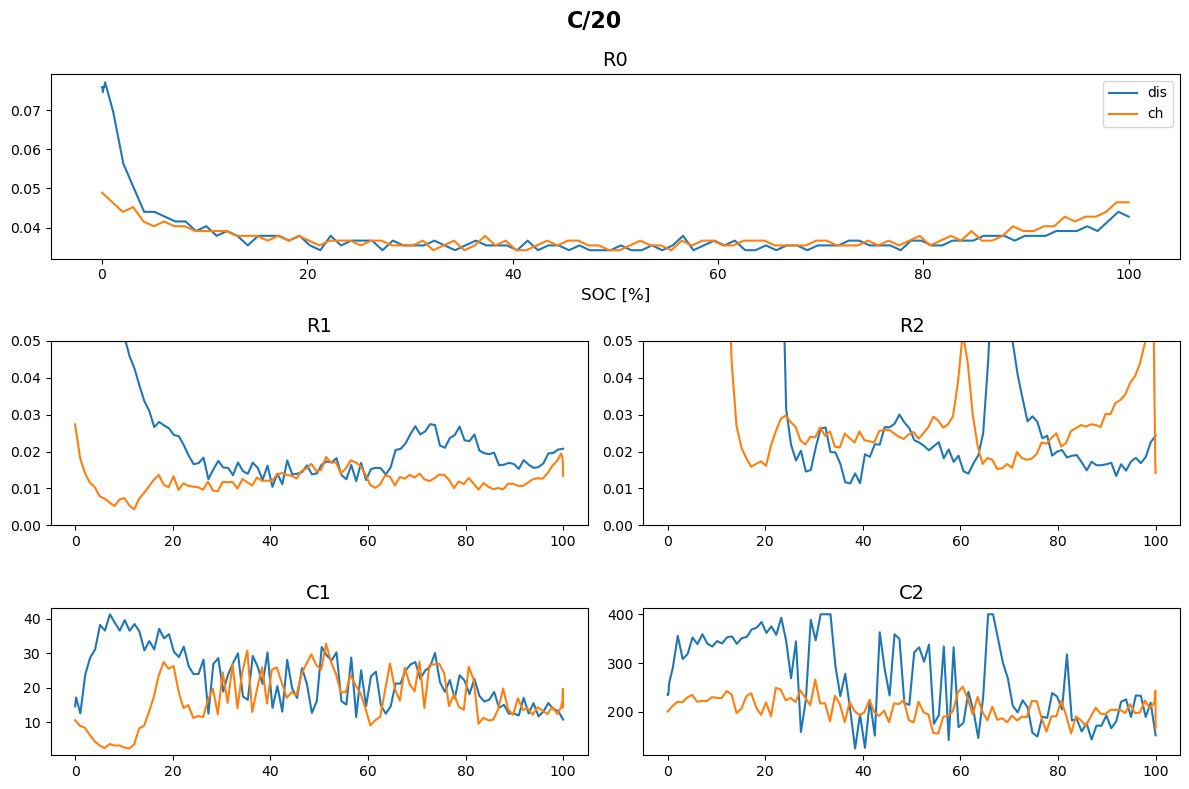

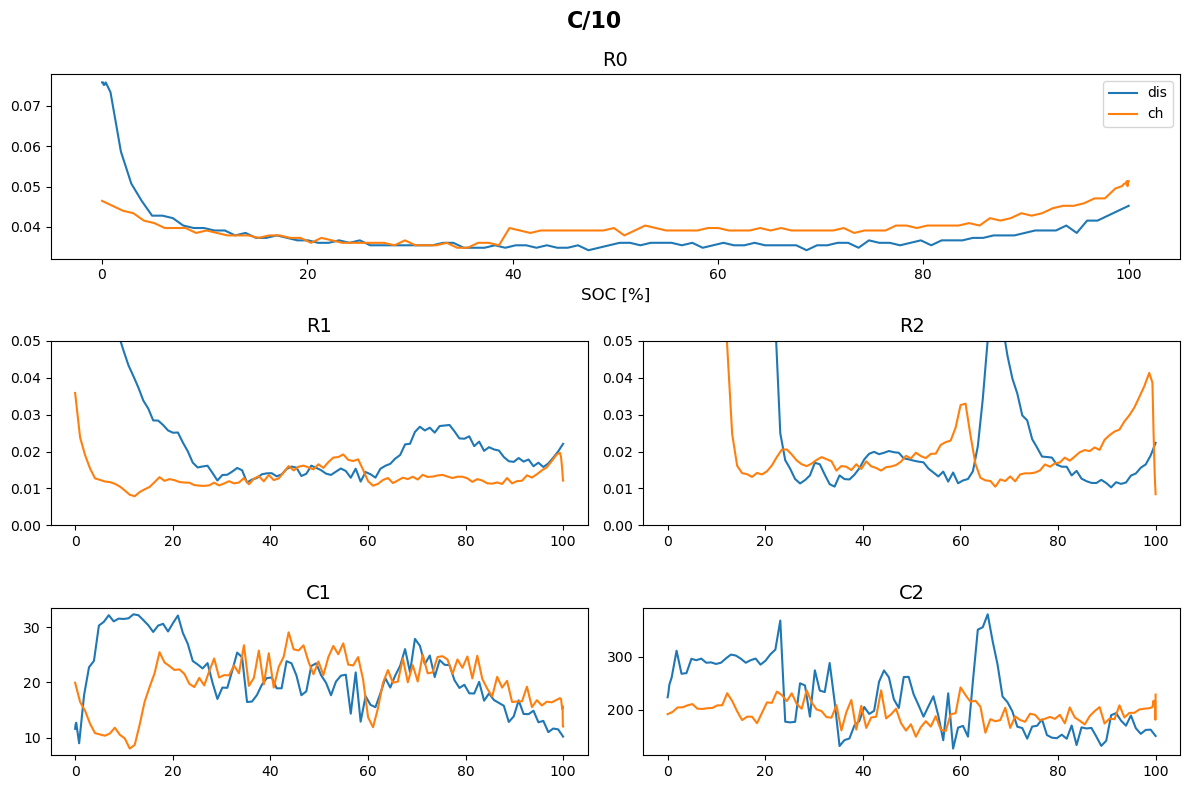

In [7]:

ylims={"C/20":0.05,"C/10":0.05,"C/5":0.05, "C/2":0.04,
       "5.1A":0.012,"1.5C":0.012,"1C":0.018,"3C/4":0.025}
#--------------------------------
#über Spannung oder SOC
xAchse_t="SOC[%]"
# xAchse_t="U[V]"
#-------------------------------

for c in fit_all.keys():
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8])  # 3 Zeilen, 2 Spalten

    ax00 = fig.add_subplot(gs[0, :])  # obere Reihe
    ax10 = fig.add_subplot(gs[1, 0])  # mitte links
    ax11 = fig.add_subplot(gs[1, 1])  # mitte rechts
    ax20 = fig.add_subplot(gs[2, 0])  # unten links
    ax21 = fig.add_subplot(gs[2, 1])  # unten rechts

    # Plotten
    if xAchse_t=="SOC[%]":
        x_t1=IR_all[c][0][0,:]/IR_all[c][0][0,0]*100
        x_t2=IR_all[c][1][0,:]/IR_all[c][1][0,-1]*100
    elif xAchse_t=="U[V]":
       x_t1=IR_all[c][0][1,:]
       x_t2=IR_all[c][1][1,:]

    ax00.plot(x_t1, fit_all[c][0][1,:], label="dis")
    ax10.plot(x_t1, fit_all[c][0][2,:])
    ax20.plot(x_t1, fit_all[c][0][3,:])
    ax11.plot(x_t1, fit_all[c][0][4,:])
    ax21.plot(x_t1, fit_all[c][0][5,:])

    ax00.plot(x_t2, fit_all[c][1][1,:], label="ch")
    ax10.plot(x_t2, fit_all[c][1][2,:])
    ax20.plot(x_t2, fit_all[c][1][3,:])
    ax11.plot(x_t2, fit_all[c][1][4,:])
    ax21.plot(x_t2, fit_all[c][1][5,:])

    # Achsen Titel
    ax00.set_title("R0",fontsize=14)
    ax10.set_title("R1",fontsize=14)
    ax11.set_title("R2",fontsize=14)
    ax20.set_title("C1",fontsize=14)
    ax21.set_title("C2",fontsize=14)

    # ylim
    if xAchse_t=="SOC[%]":
        ax10.set_ylim(0, ylims[c])
        ax11.set_ylim(0, ylims[c])

    # Legende
    ax00.legend()
    ax00.set_xlabel("SOC [%]", fontsize=12)

    # Gesamttitel
    fig.suptitle(c, fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Etwas Platz für den Suptitle
    plt.show()

Parameter der Fits für alle C-Raten in einen Plot. Plotten über den SOC

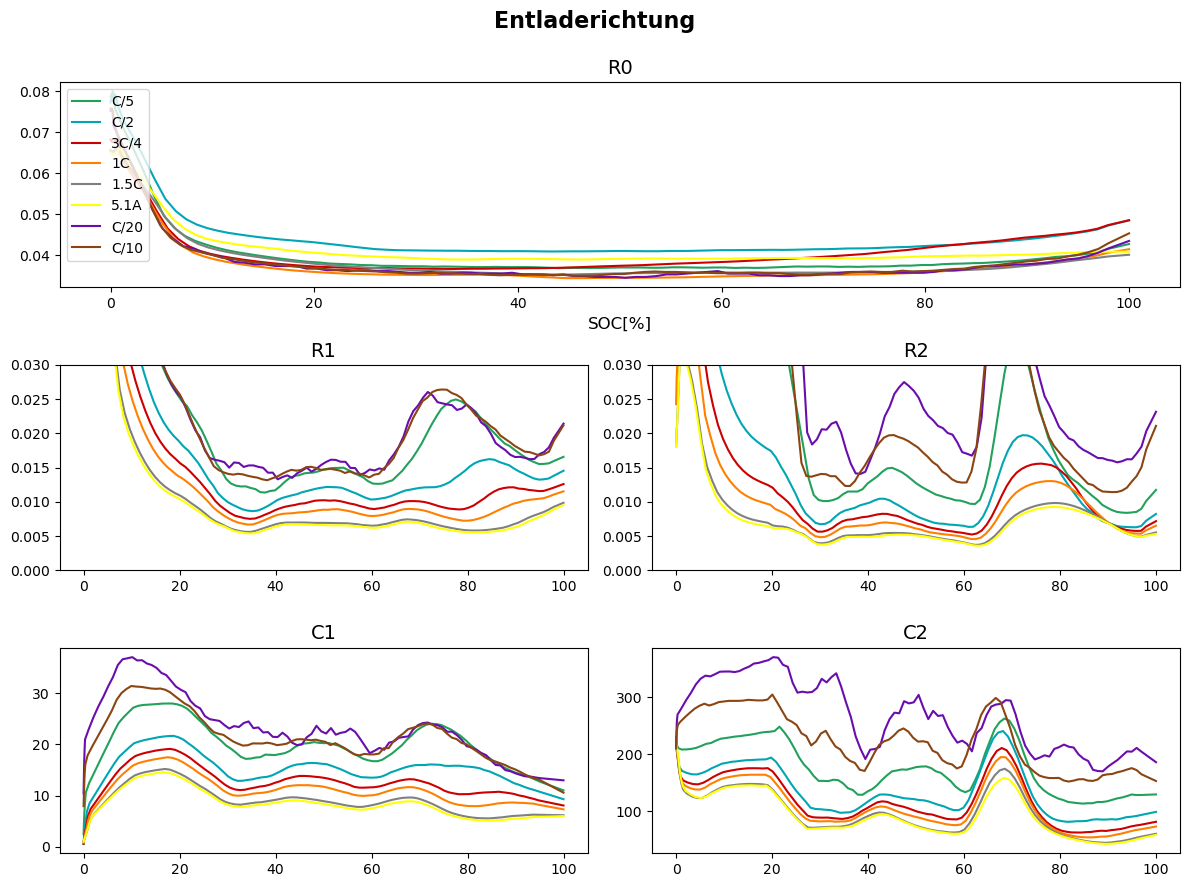

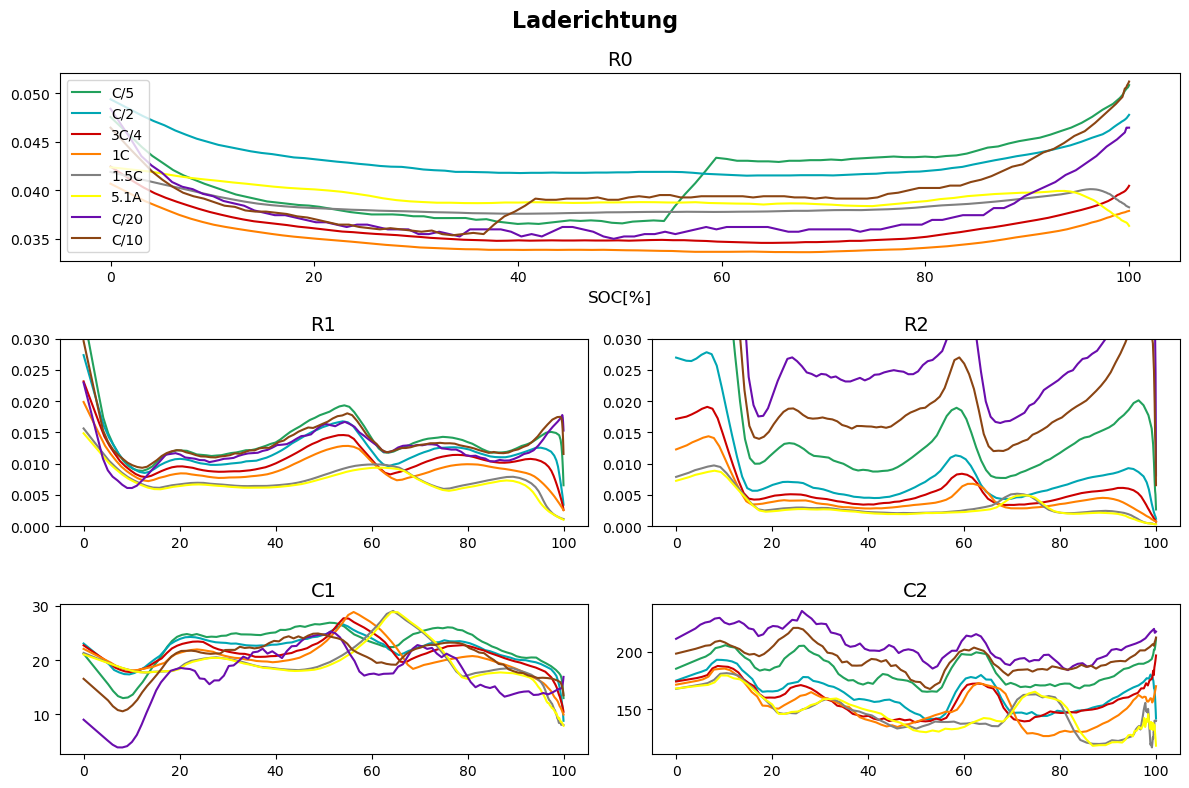

In [8]:
"""Alle Fits ein Plot"""
#---------------------------
#über Spannung oder SOC
xAchse="SOC[%]"
# xAchse="U[V]"
#---------------------------

col = ['#22a15c', '#00a6b3', '#cc0000', '#ff8000', '#808080', 'yellow', '#6a0dad', '#8B4513']
i=0
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])  # 3 Zeilen, 2 Spalten

ax00 = fig.add_subplot(gs[0, :])  # obere Reihe 
ax10 = fig.add_subplot(gs[1, 0])  # mitte links
ax11 = fig.add_subplot(gs[1, 1])  # mitte rechts
ax20 = fig.add_subplot(gs[2, 0])  # unten links
ax21 = fig.add_subplot(gs[2, 1])  # unten rechts

for c in fit_all.keys():
    if xAchse=="SOC[%]":
        x=IR_all[c][0][0,:]/IR_all[c][0][0,0]*100
    elif xAchse=="U[V]":
        x=IR_all[c][0][1,:]

    ax00.plot(x,savgol_filter(fit_all[c][0][1,:],6,1),color=col[i],label=c)
    ax10.plot(x,savgol_filter(fit_all[c][0][2,:],6,1),color=col[i])
    ax20.plot(x,savgol_filter(fit_all[c][0][3,:],11,1),color=col[i])
    ax11.plot(x,savgol_filter(fit_all[c][0][4,:],6,1),color=col[i])
    ax21.plot(x,savgol_filter(fit_all[c][0][5,:],8,1),color=col[i])

    i+=1

# Achsen Titel
ax00.set_title("R0",fontsize=14)
ax10.set_title("R1",fontsize=14)
ax11.set_title("R2",fontsize=14)
ax20.set_title("C1",fontsize=14)
ax21.set_title("C2",fontsize=14)
if xAchse=="SOC[%]":
    ax10.set_ylim(0, 0.03)
    ax11.set_ylim(0, 0.03)
ax00.legend(loc="upper left")
ax00.set_xlabel(xAchse, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Etwas Platz für den Suptitle
fig.suptitle("Entladerichtung", fontsize=16, fontweight='bold', y=0.98)
plt.show()





i=0
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8])  # 3 Zeilen, 2 Spalten

ax00 = fig.add_subplot(gs[0, :])  # obere Reihe 
ax10 = fig.add_subplot(gs[1, 0])  # mitte links
ax11 = fig.add_subplot(gs[1, 1])  # mitte rechts
ax20 = fig.add_subplot(gs[2, 0])  # unten links
ax21 = fig.add_subplot(gs[2, 1])  # unten rechts

for c in fit_all.keys():
    if xAchse=="SOC[%]":
        x=IR_all[c][1][0,:]/IR_all[c][1][0,-1]*100
    elif xAchse=="U[V]":
        x=IR_all[c][1][1,:]
    ax00.plot(x,savgol_filter(fit_all[c][1][1,:],5,1),color=col[i],label=c)
    ax10.plot(x,savgol_filter(fit_all[c][1][2,:],7,1),color=col[i])
    ax20.plot(x,savgol_filter(fit_all[c][1][3,:],11,1),color=col[i])
    ax11.plot(x,savgol_filter(fit_all[c][1][4,:],6,1),color=col[i])
    ax21.plot(x,savgol_filter(fit_all[c][1][5,:],9,1),color=col[i])

    i+=1

# Achsen Titel
ax00.set_title("R0",fontsize=14)
ax10.set_title("R1",fontsize=14)
ax11.set_title("R2",fontsize=14)
ax20.set_title("C1",fontsize=14)
ax21.set_title("C2",fontsize=14)
if xAchse=="SOC[%]":
    ax10.set_ylim(0, 0.03)
    ax11.set_ylim(0, 0.03)
ax00.legend(loc="upper left")
ax00.set_xlabel(xAchse, fontsize=12) 

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Etwas Platz für den Suptitle
fig.suptitle("Laderichtung", fontsize=16, fontweight='bold', y=0.98)
plt.show()



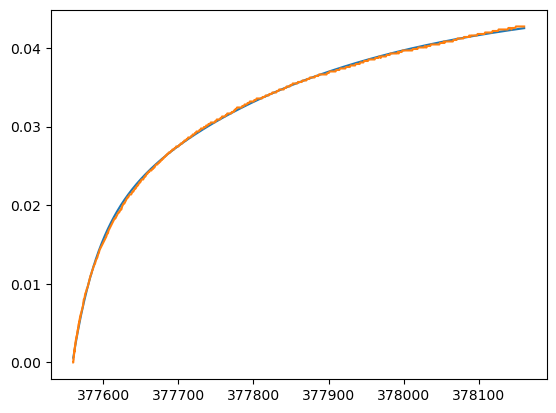

In [9]:
d=90
c1=14
c2="C/10"
plt.plot(np.linspace(hppc_data[c1][d][0,0],hppc_data[c1][d][-1,0],len(plot_all[c2][0][d])),plot_all[c2][0][d][:])
plt.plot(hppc_data[c1][d][:,0],hppc_data[c1][d][:,2]-hppc_data[c1][d][0,2])
plt.show()

In [21]:
"""Butler-Volmer"""
moddata={}
for direction in OCV.keys():
    
    for c in OCV[direction].keys():
        moddata[f"{c}"+" "+f"{direction}"]={}
        if direction=="ch":
            moddata[f"{c}"+" "+f"{direction}"]["U"]=IR_all[c][1]
        elif direction=="dis":
            moddata[f"{c}"+" "+f"{direction}"]["U"]=np.array([IR_all[c][0][0,:],IR_all[c][0][1,:],-IR_all[c][0][2,:]])
        else:
            print("falsche Laderichtung")
        moddata[f"{c}"+" "+f"{direction}"]["I"]=OCV[direction][c][5,3]
        # moddata[f"{c}"+" "+f"{direction}"]["I"]=np.mean(OCV[direction][c][1:10,3])

   

In [22]:
import copy

testdict = copy.deepcopy(moddata)
testdictU=copy.deepcopy(testdict)
testdictQ=copy.deepcopy(testdict)

minvol=[]
maxvol=[]  
mincap=[]
maxcap=[]  
for i in testdict.keys():
    mincap.append(min(testdict[i]["U"][0,:]))
    maxcap.append(max(testdict[i]["U"][0,:]))
    minvol.append(min(testdict[i]["U"][1,:]))
    maxvol.append(max(testdict[i]["U"][1,:]))
commonvol=np.linspace(max(minvol),min(maxvol),100)
commoncap=np.linspace(max(mincap),min(maxcap),100)
for i in testdict.keys():
    
    f1U=interp1d(testdict[i]["U"][1,:],testdict[i]["U"][2,:],kind='linear')
    interpU=f1U(commonvol)
    testdictU[i]["U"]=np.array([commonvol,interpU])
    f1Q=interp1d(testdict[i]["U"][0,:],testdict[i]["U"][2,:],kind='linear')
    interpQ=f1Q(commoncap)
    testdictQ[i]["U"]=np.array([commoncap,interpQ])

In [12]:
# Butler Volmer testen
# e=10
# U_data=np.array([testdict2["1C dis"]["U"][1,e],
#                  testdict2["3C/4 dis"]["U"][1,e],testdict2["C/2 dis"]["U"][1,e],testdict2["C/5 dis"]["U"][1,e],
#                  0,
#                  testdict2["C/5 ch"]["U"][1,e],testdict2["C/2 ch"]["U"][1,e],testdict2["3C/4 ch"]["U"][1,e],
#                  testdict2["1C ch"]["U"][1,e]])
# #U_data=[-0.478901,-0.018507,0,0.0198429,0.048844]
# I_data=np.array([testdict2["1C dis"]["I"],
#                  testdict2["3C/4 dis"]["I"],testdict2["C/2 dis"]["I"],testdict2["C/5 dis"]["I"],
#                  0,
#                  testdict2["C/5 ch"]["I"],testdict2["C/2 ch"]["I"],testdict2["3C/4 ch"]["I"],
#                 testdict2["1C ch"]["I"]])


# p0 = [1.5, 0.5, 0.01]  # Startwerte: I0, alpha, IR
# # bounds = (
# #     [0, 0.1, 0.01],  # Untergrenzen: I0, alpha, IR
# #     [1.0, 2, 10],     # Obergrenzen: I0, alpha, IR
# # )

# # popt, pcov = curve_fit(
# #     model2, I_data, U_data,
# #     p0=p0, bounds=bounds
# # )
# solution = fmin(cost_func2,p0,args=(U_data,I_data))  
# # Ausgabe der Fit-Ergebnisse
# I0_fit, alpha_fit, R_fit = solution
# print(f"Fit-Ergebnisse:\nI0: {I0_fit:.4e}\nalpha: {alpha_fit:.4f}\nR: {R_fit:.4f}")

# # Fit-Kurve berechnen
# U_fit = np.linspace(min(U_data), max(U_data), 100)
# I_fit=np.linspace(min(I_data),max(I_data),100)
# I_fit = model2(U_fit,I_fit, solution)

# # Plot der Daten und des Fits
# plt.scatter( U_data,I_data, label="Daten", color="blue")
# plt.plot( U_fit,I_fit ,label="Fit", color="red")

# plt.legend()
# plt.grid()
# plt.title("Curve-Fit mit modifizierter Butler-Volmer-Gleichung")
# plt.show()

Butler Volmer Fit anwenden

In [43]:
"""Butler Volmer Fit über Spannung"""
butler_fit={"Kapazität":{},"Spannung":{}}
butler_plot={"Kapazität":{},"Spannung":{}}
butler_fit["Spannung"],butler_plot["Spannung"]=butler_volmer_fit(testdictU)
butler_fit["Kapazität"],butler_plot["Kapazität"]=butler_volmer_fit(testdictQ)

# for a in range(len(testdictU["C/2 ch"]["U"][0,:])):
#     Udata=[0]
#     Idata=[0]
#     for i in testdictU.keys():
#         if "5.1A" not in i and "1.5C" not in i:
#             Udata.append(testdictU[i]["U"][1,a])
#             Idata.append(testdictU[i]["I"])
#             print(i)
#     Udata=np.sort(np.array(Udata))
#     Idata=np.sort(np.array(Idata))
#     p0 = [1.5, 0.5, 0.01]  # Startwerte: I0, alpha, IR
#     # bounds = (
#     #     [0, 0.1, 0.01],  # Untergrenzen: I0, alpha, IR
#     #     [1.0, 2, 10],     # Obergrenzen: I0, alpha, IR
#     # )

#     # popt, pcov = curve_fit(
#     #     model2, I_data, U_data,
#     #     p0=p0, bounds=bounds
#     # )
#     solution = fmin(cost_func2,p0,args=(Udata,Idata))  
#     # Ausgabe der Fit-Ergebnisse
#     I0_fit, alpha_fit, R_fit = solution
#     print(f"Fit-Ergebnisse:\nI0: {I0_fit:.4e}\nalpha: {alpha_fit:.4f}\nR: {R_fit:.4f}")

#     # Fit-Kurve berechnen
#     Ufit = np.linspace(min(Udata), max(Udata), 100)
#     Ifit=np.linspace(min(Idata),max(Idata),100)
#     Ifitted = model2(Ufit,Ifit, solution)
    
#     fit_t=np.array([testdictU["C/2 ch"]["U"][0,a],I0_fit, alpha_fit, R_fit])
#     plot_t=np.array([Ufit,Ifitted]).T
#     if a == 0:
#         butler_fit_t = fit_t
#     else:
#         butler_fit_t = np.column_stack([butler_fit_t, fit_t])
#     vol=testdictU["C/2 ch"]["U"][0,a]
#     butler_plot["Spannung"][f"{vol:.4f}"+" V"]=plot_t 
# butler_fit["Spannung"]=butler_fit_t
#%%



C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.072430
         Iterations: 323
         Function evaluations: 543
Fit-Ergebnisse:
I0: 9.9990e-01
alpha: 0.6219
R: 0.0239
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.060660
         Iterations: 303
         Function evaluations: 512
Fit-Ergebnisse:
I0: 1.0015e+00
alpha: 0.6119
R: 0.0236
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.055390
         Iterations: 263
         Function evaluations: 451
Fit-Ergebnisse:
I0: 1.0031e+00
alpha: 0.6016
R: 0.0233
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
 

C:\Users\maxim\AppData\Local\Temp\ipykernel_12088\3654229828.py:364: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  solution = fmin(cost_func2,p0,args=(Udata,Idata))


Fit-Ergebnisse:
I0: 9.3740e-01
alpha: 0.4868
R: 0.0163
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.087325
         Iterations: 349
         Function evaluations: 592
Fit-Ergebnisse:
I0: 9.4501e-01
alpha: 0.4878
R: 0.0162
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.083401
         Iterations: 67
         Function evaluations: 120
Fit-Ergebnisse:
I0: 8.1279e-01
alpha: 0.4903
R: 0.0139
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/20 dis
C/10 dis
Optimization terminated successfully.
         Current function value: 1.053970
         Iterations: 288
         Function evaluations: 491
Fit-Ergebnisse:
I0: 9.6910e-01
alpha: 0.4917
R: 0.0162
C/5 ch
C/2 ch
3C/4 ch
1C ch
C/20 ch
C/10 ch
C/5 dis
C/2 dis
3C/4 dis
1C dis
C/2

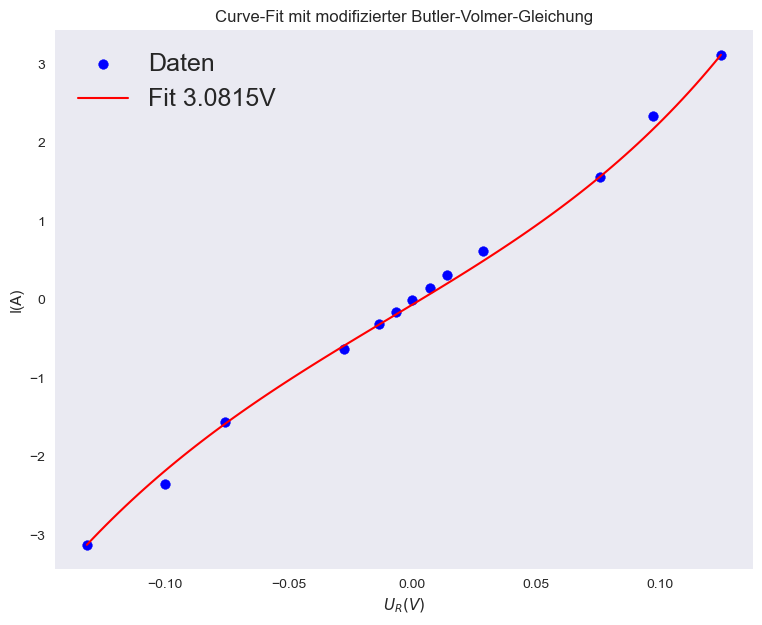

In [44]:

e = 10
U = np.array([testdictU["1C dis"]["U"][1, e],
              testdictU["3C/4 dis"]["U"][1, e], testdictU["C/2 dis"]["U"][1, e], testdictU["C/5 dis"]["U"][1, e],
              testdictU["C/10 dis"]["U"][1, e], testdictU["C/20 dis"]["U"][1, e],
              0,
              testdictU["C/20 ch"]["U"][1, e], testdictU["C/10 ch"]["U"][1, e],
              testdictU["C/5 ch"]["U"][1, e], testdictU["C/2 ch"]["U"][1, e], testdictU["3C/4 ch"]["U"][1, e],
              testdictU["1C ch"]["U"][1, e]])

I = np.array([testdictU["1C dis"]["I"],
              testdictU["3C/4 dis"]["I"], testdictU["C/2 dis"]["I"], testdictU["C/5 dis"]["I"],
              testdictU["C/10 dis"]["I"], testdictU["C/20 dis"]["I"],
              0,
              testdictU["C/20 ch"]["I"], testdictU["C/10 ch"]["I"],
              testdictU["C/5 ch"]["I"], testdictU["C/2 ch"]["I"], testdictU["3C/4 ch"]["I"],
              testdictU["1C ch"]["I"]])

plt.scatter(U, I, label="Daten", color="blue")
plt.plot(butler_plot["Spannung"]["3.0815"][:, 0], butler_plot["Spannung"]["3.0815"][:, 1], label="Fit 3.0815V", color="red")

plt.xlabel("$U_{R}(V)$")
plt.ylabel("I(A)")
plt.legend()
plt.grid()
plt.title("Curve-Fit mit modifizierter Butler-Volmer-Gleichung")
plt.show()




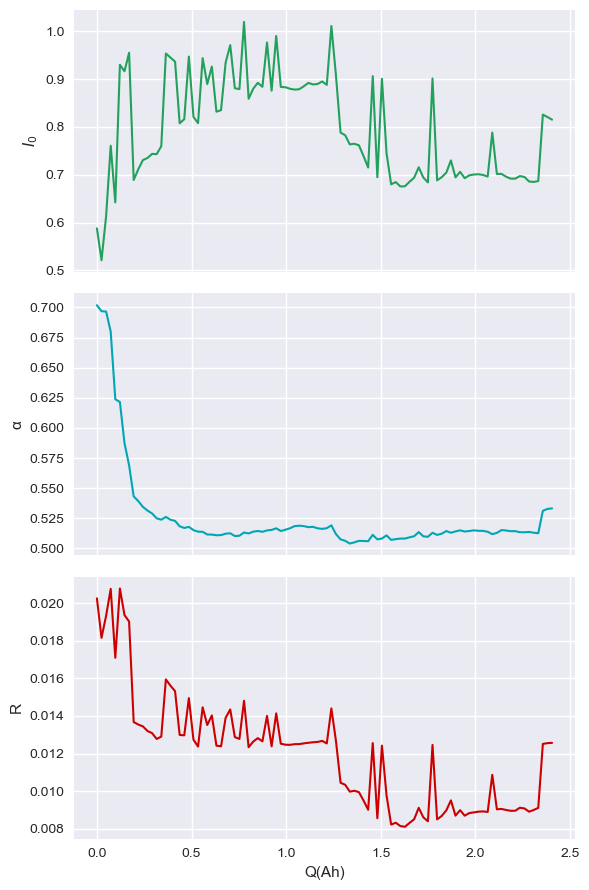

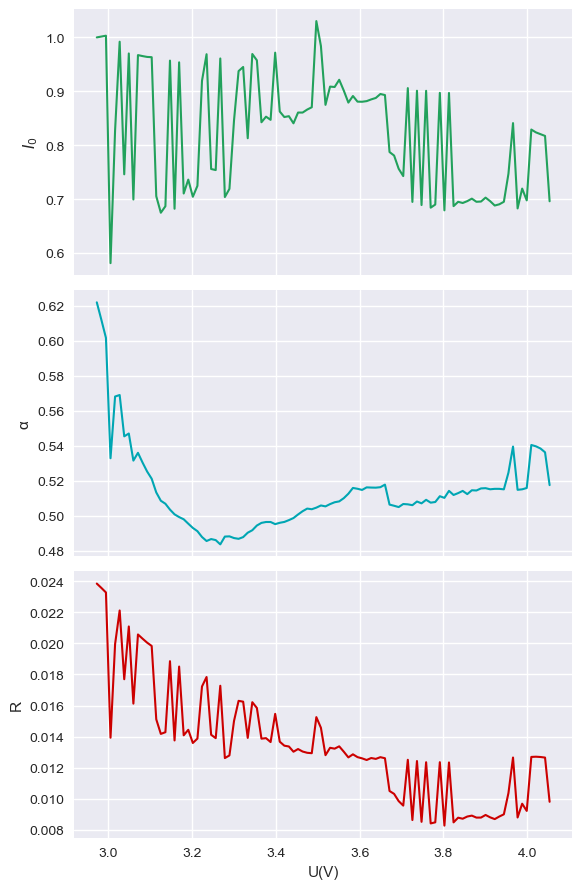

In [45]:


"""Parameter plotten"""
colors = ['#22a15c', '#00a6b3', '#cc0000', '#ff8000', '#808080',"yellow"]
for x in butler_fit.keys():
# alpha
    fig, axes = plt.subplots(3, 1, figsize=(6, 9), sharex=True)  # 3 Zeilen, 1 Spalte
    
    # Erster Plot
    axes[0].plot(butler_fit[x][0, :], butler_fit[x][1, :],color=colors[0])
    axes[0].grid(True)
    axes[0].set_ylabel("$I_{0}$")
    
    # Zweiter Plot
    axes[1].plot(butler_fit[x][0, :], butler_fit[x][2, :],color=colors[1])
    axes[1].grid(True)
    axes[1].set_ylabel("α")
    
    # Dritter Plot
    axes[2].plot(butler_fit[x][0, :], butler_fit[x][3, :],color=colors[2])
    axes[2].grid(True)
    if x=="Spannung":
        axes[2].set_xlabel("U(V)")
    elif x=="Kapazität":
        axes[2].set_xlabel("Q(Ah)")
    else:
        print("Fehler: unbekannte x-Achse")

        
    axes[2].set_ylabel("R")
    
    plt.tight_layout()  # Optimiert die Abstände zwischen den Plots
    plt.show()



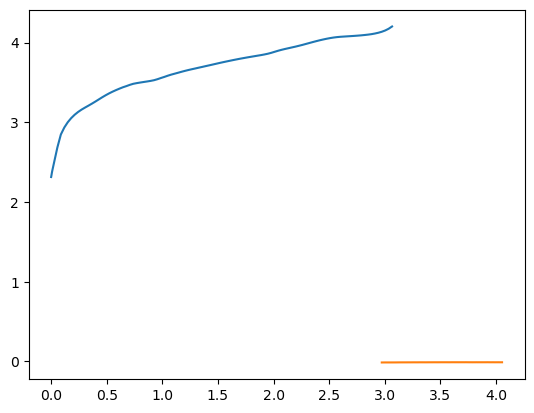

In [16]:

a = "C/10 dis"
plt.plot(testdict[a]["U"][0, :], testdict[a]["U"][1, :])
plt.plot(testdictU[a]["U"][0, :], testdictU[a]["U"][1, :])


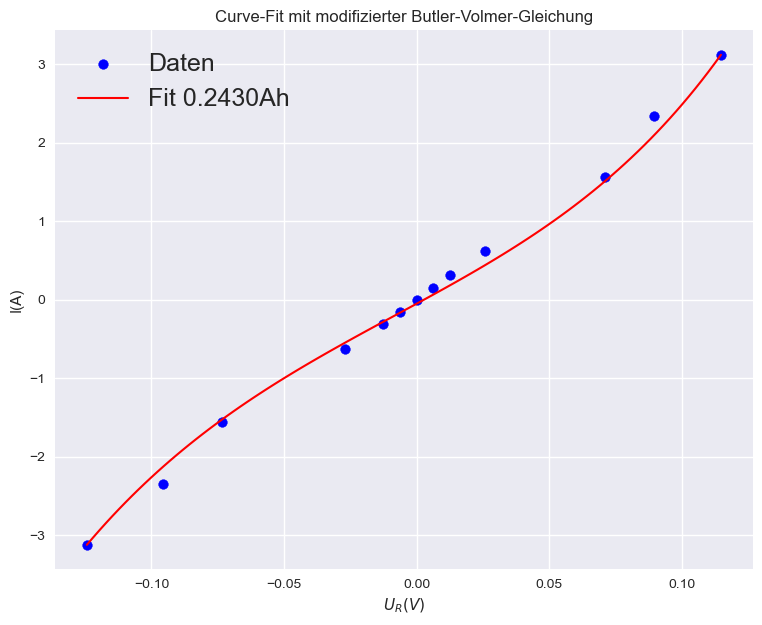

In [46]:


e = 10
U = np.array([testdictQ["1C dis"]["U"][1, e],
              testdictQ["3C/4 dis"]["U"][1, e], testdictQ["C/2 dis"]["U"][1, e], testdictQ["C/5 dis"]["U"][1, e],
              testdictQ["C/10 dis"]["U"][1, e], testdictQ["C/20 dis"]["U"][1, e],
              0,
              testdictQ["C/20 ch"]["U"][1, e], testdictQ["C/10 ch"]["U"][1, e],
              testdictQ["C/5 ch"]["U"][1, e], testdictQ["C/2 ch"]["U"][1, e], testdictQ["3C/4 ch"]["U"][1, e],
              testdictQ["1C ch"]["U"][1, e]])

I = np.array([testdictQ["1C dis"]["I"],
              testdictQ["3C/4 dis"]["I"], testdictQ["C/2 dis"]["I"], testdictQ["C/5 dis"]["I"],
              testdictQ["C/10 dis"]["I"], testdictQ["C/20 dis"]["I"],
              0,
              testdictQ["C/20 ch"]["I"], testdictQ["C/10 ch"]["I"],
              testdictQ["C/5 ch"]["I"], testdictQ["C/2 ch"]["I"], testdictQ["3C/4 ch"]["I"],
              testdictQ["1C ch"]["I"]])

plt.scatter(U, I, label="Daten", color="blue")
plt.plot(butler_plot["Kapazität"]["0.2430"][:, 0], butler_plot["Kapazität"]["0.2430"][:, 1], label="Fit 0.2430Ah", color="red")

plt.xlabel("$U_{R}(V)$")
plt.ylabel("I(A)")

plt.legend()
plt.grid(True)
plt.title("Curve-Fit mit modifizierter Butler-Volmer-Gleichung")
plt.show()


Butler Volmer Fits über Kapazität zusammenlegen

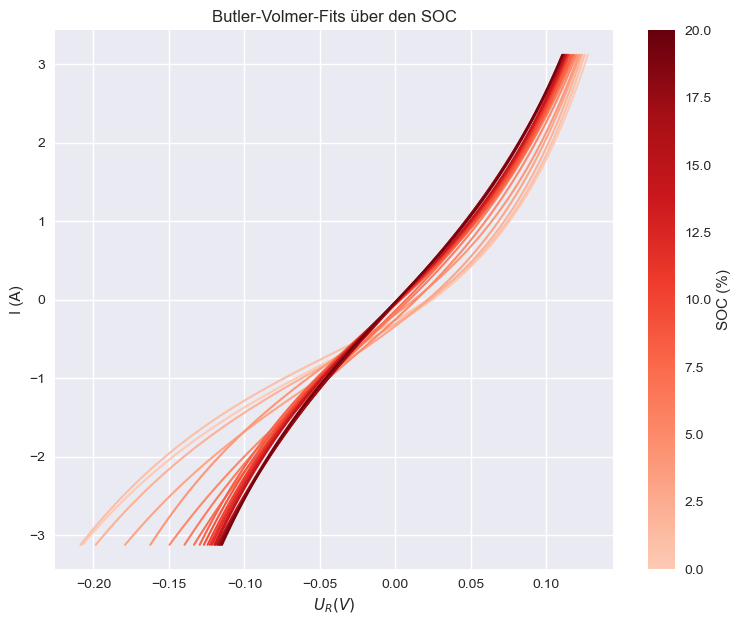

In [47]:

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Kapazitäten von str in float umwandeln und max kapazität bestimmen
cap_float = [float(k) for k in butler_plot["Kapazität"].keys()]
maxcap = max(cap_float)

#---------------------------------------
#SOC obere Grenze einstellen
soc_grenze=20
#---------------------------------------

# Colormap vorbereiten - aber NUR einen kräftigeren Teil nehmen
color_counter=0
for i in(butler_plot["Kapazität"].keys()):
    if (float(i) / maxcap) * 100 <= soc_grenze:
        color_counter+=1

cmap_full = cm.Reds
cmap = mcolors.LinearSegmentedColormap.from_list(
    'my_reds', cmap_full(np.linspace(0.2, 1.0, color_counter)))


norm = mcolors.Normalize(vmin=0, vmax=soc_grenze)  # SoC von 0% bis grenze

fig, ax = plt.subplots()
for i in butler_plot["Kapazität"].keys():
    soc = (float(i) / maxcap) * 100  # SOC in %
    if soc<=soc_grenze:
        color = cmap(norm(soc))  # Hole die Farbe aus der modifizierten Colormap
        ax.plot(butler_plot["Kapazität"][i][:, 0], butler_plot["Kapazität"][i][:, 1],
            label=f"SOC={soc:.1f}%", color=color)

# Achsenbeschriftungen usw.
ax.set_ylabel("I (A)")
ax.set_xlabel("$U_{R}(V)$")
ax.grid(True)
ax.set_title("Butler-Volmer-Fits über den SOC")

# Colorbar hinzufügen
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('SOC (%)')

plt.show()